# Quality Control Reports
Create a report quality checking an individual unit. Unit exclusion criteria:

- firing rate < 0.15 Hz
- presence ration < 50%
- any bad unit identified from visual inspection


In [1]:
# Imports
from convnwb.io import load_nwbfile

...

Ellipsis

In [53]:
import numpy as np
import os
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.utils.extract import get_range
from spiketools.utils.epoch import epoch_spikes_by_range, epoch_spikes_by_event
from spiketools.plts.utils import save_figure

In [3]:
config Completer.use_jedi = False

In [4]:
import sys
sys.path.append('../code')
from plts import plot_spikes_trial

## Settings

In [57]:
# Define the base data folder
data_folder = '/Users/weijiazhang/Data/Train_NWB'
# Define subject information
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1027J',
    'session' : 0    
}

In [58]:
# Set which example unit to extract
uind = 2

## Load Data

In [69]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x16064266976
Fields:
  colnames: ['start_time' 'stop_time' 'drive_type' 'feedback_start_time'
 'feedback_stop_time' 'fixation_start_time' 'fixation_stop_time'
 'hold_start_time' 'hold_stop_time' 'movement_start_time'
 'movement_stop_time' 'object' 'object_position' 'response_error'
 'response_position' 'response_time' 'trial_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    drive_type <class 'hdmf.common.table.VectorData'>,
    feedback_start_time <class 'hdmf.common.table.VectorData'>,
    feedback_stop_time <class 'hdmf.common.table.VectorData'>,
    fixation_start_time <class 'hdmf.common.table.VectorData'>,
    fixation_stop_time <class 'hdmf.common.table.VectorData'>,
    hold_start_time <class 'hdmf.common.table.VectorData'>,
    hold_stop_time <class 'hdmf.common.table.VectorData'>,
    movement_start_time <class 'hdmf.common.table.VectorData'>,
    movement_st

In [60]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)
nwbfiles

['TRAIN_EU001_session_0.nwb',
 'TRAIN_R1027J_session_0.nwb',
 'TRAIN_R1027J_session_1.nwb',
 'TRAIN_R1030J_session_0.nwb',
 'TRAIN_R1030J_session_1.nwb',
 'TRAIN_R1030J_session_2.nwb',
 'TRAIN_R1139C_session_0.nwb',
 'TRAIN_R1139C_session_1.nwb',
 'TRAIN_R1152C_session_0.nwb',
 'TRAIN_R1182C_session_0.nwb',
 'TRAIN_R1219C_session_0.nwb',
 'TRAIN_R1241J_session_0.nwb',
 'TRAIN_R1268T_session_0.nwb',
 'TRAIN_R1278E_session_0.nwb',
 'TRAIN_R1278E_session_1.nwb',
 'TRAIN_R1278E_session_3.nwb',
 'TRAIN_R1297T_session_0.nwb',
 'TRAIN_R1299T_session_0.nwb',
 'TRAIN_R1315T_session_0.nwb',
 'TRAIN_R1315T_session_1.nwb',
 'TRAIN_R1354E_session_0.nwb',
 'TRAIN_R1354E_session_1.nwb',
 'TRAIN_R1362E_session_0.nwb',
 'TRAIN_R1362E_session_1.nwb',
 'TRAIN_R1414E_session_1.nwb',
 'TRAIN_UT048_session_0.nwb',
 'TRAIN_UT088_session_0.nwb']

In [61]:
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x16052237840
Fields:
  colnames: ['start_time' 'stop_time' 'drive_type' 'feedback_start_time'
 'feedback_stop_time' 'fixation_start_time' 'fixation_stop_time'
 'hold_start_time' 'hold_stop_time' 'movement_start_time'
 'movement_stop_time' 'object' 'object_position' 'response_error'
 'response_position' 'response_time' 'trial_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    drive_type <class 'hdmf.common.table.VectorData'>,
    feedback_start_time <class 'hdmf.common.table.VectorData'>,
    feedback_stop_time <class 'hdmf.common.table.VectorData'>,
    fixation_start_time <class 'hdmf.common.table.VectorData'>,
    fixation_stop_time <class 'hdmf.common.table.VectorData'>,
    hold_start_time <class 'hdmf.common.table.VectorData'>,
    hold_stop_time <class 'hdmf.common.table.VectorData'>,
    movement_start_time <class 'hdmf.common.table.VectorData'>,
    movement_st

In [73]:
# Get the trail information
trial_starts = nwbfile.trials.start_time[:]
trial_ends = nwbfile.trials.stop_time[:]
hold_starts = nwbfile.trials.hold_start_time[:]
hold_stops = nwbfile.trials.hold_stop_time[:]
movement_start= nwbfile.trials.movement_start_time[:]
movement_end= nwbfile.trials.movement_stop_time[:]
fixation_start= nwbfile.trials.fixation_start_time[:]
fixation_end= nwbfile.trials.fixation_stop_time[:]
feedback_start= nwbfile.trials.feedback_start_time[:]
feedback_end= nwbfile.trials.feedback_stop_time[:]
response_time= nwbfile.trials.response_time[:]
response_time

array([   8.16142529,   53.38724023,  111.42515259,  155.56404419,
        210.72015967,  286.92779248,  332.73256665,  369.12100391,
        411.5930127 ,  446.74853662,  495.67109106,  541.59285693,
        591.86531641,  624.68600488,  650.55518311,  705.17933594,
        738.33300098,  771.0037002 ,  811.60884033,  851.68001831,
        900.40258691,  951.84196411,  996.09684741, 1033.88318628,
       1071.62352832, 1121.04504761, 1157.86645435, 1194.41987988,
       1234.22507666, 1279.84786353, 1326.33658936, 1380.72575879,
       1434.44897534, 1472.0533269 , 1515.52526538, 1575.58303564,
       1623.75464282, 1674.42807422, 1727.80031519, 1761.13796729,
       1811.32543286, 1854.59938501, 1897.97133057, 1939.19142749,
       1988.26497144, 2038.0874624 , 2072.64202881, 2115.97997656,
       2158.66797021, 2195.82135376, 2250.77948315, 2290.46768799,
       2326.85512524, 2382.11223364, 2428.25098413, 2482.65715259,
       2524.49520581, 2574.25170166, 2618.07461548, 2666.74618

In [63]:
# Reset movement stops per trial
movement_stops_trial = [movement_end[ind] - movement_start[ind] for ind in range(len(movement_end))]


In [78]:
# Get the spikes
spikes = nwbfile.units.get_unit_spike_times(3)
spikes

array([1734129.50353603, 1734146.45037806, 1734157.54072787,
       1734157.54939156, 1734157.55946731, 1734166.29841584,
       1734166.32529675, 1734176.60648169, 1734177.47988147,
       1734188.605652  , 1734188.61720325, 1734206.89526459,
       1734210.4915635 , 1734213.31377834, 1734213.32732631,
       1734213.53354928, 1734213.54811097, 1734213.57548237,
       1734213.62217688, 1734213.78364162, 1734214.38523091,
       1734214.39711906, 1734221.01356272, 1734229.32117228,
       1734241.18191791, 1734241.19055087, 1734241.21230075,
       1734246.74008834, 1734254.496857  , 1734258.13736119,
       1734259.03589091, 1734259.19250109, 1734259.22721428,
       1734259.24650766, 1734260.94381831, 1734263.55993306,
       1734268.03829544, 1734278.25475297, 1734280.61017841,
       1734280.62197541, 1734292.90856134, 1734294.92846259,
       1734325.36120056, 1734327.34396084, 1734339.01860528,
       1734340.53101278, 1734395.3492865 , 1734408.65930959,
       1734462.89660631,

## Example unit

In [65]:
# Epoch & reset spikes within each movement period per trial
name = nwbfile.session_id + '_U' + str(uind).zfill(2)
spikes_trial = epoch_spikes_by_range(spikes, movement_start, movement_end, reset=True)

In [66]:
# Compute the firing rate per trial
movement_spikes = []
frs = np.zeros(len(spikes_trial))
for ind in range(len(spikes_trial)): 
    t_spikes = get_range(spikes, movement_start[ind],movement_end[ind])
    movement_spikes.append(t_spikes)
    movement_spikes_all = np.concatenate(movement_spikes).ravel()
    
    frs[ind] = compute_firing_rate(spikes_trial[ind])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [67]:
movement_spikes_all

array([], dtype=float64)

In [16]:
# Define hlines
hlines = [7.5, 15.5]
movement_start= list(movement_start)

movement_end= list(movement_end)
response_time = list(response_time)

Figure1: 
- blue: cell firing
- orange:movement start
- purple: movement period end

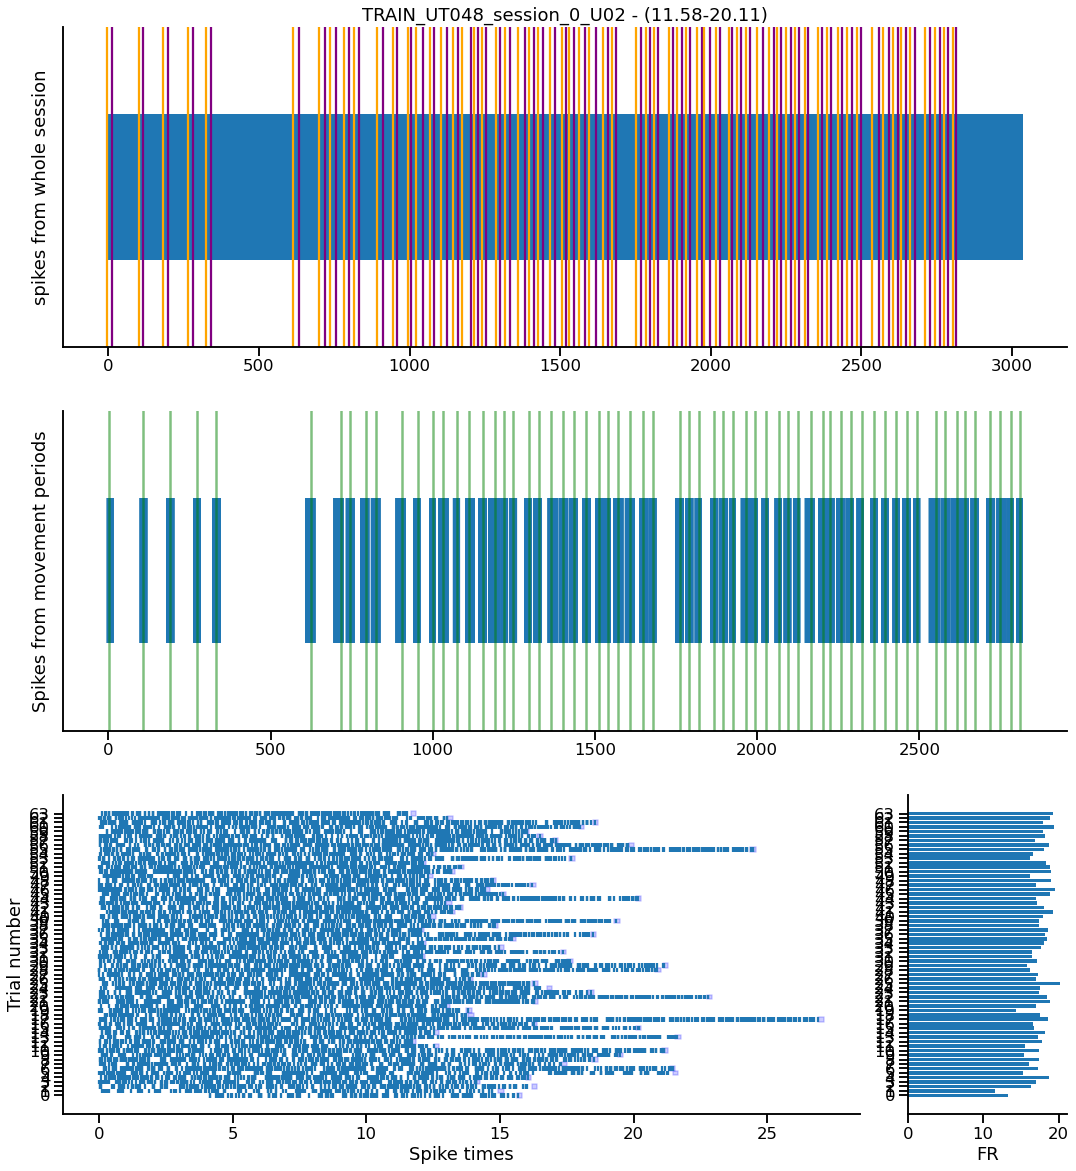

In [17]:
# Plot the unit report for one example unit 
plot_spikes_trial(spikes, spikes_trial, movement_spikes_all, movement_start, movement_end, 
                  movement_stops_trial, response_time, frs, name, hlines)

In [19]:
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x5098799936
Fields:
  colnames: ['start_time' 'stop_time' 'drive_type' 'feedback_start_time'
 'feedback_stop_time' 'fixation_start_time' 'fixation_stop_time'
 'hold_start_time' 'hold_stop_time' 'movement_start_time'
 'movement_stop_time' 'object' 'object_position' 'response_error'
 'response_position' 'response_time' 'trial_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    drive_type <class 'hdmf.common.table.VectorData'>,
    feedback_start_time <class 'hdmf.common.table.VectorData'>,
    feedback_stop_time <class 'hdmf.common.table.VectorData'>,
    fixation_start_time <class 'hdmf.common.table.VectorData'>,
    fixation_stop_time <class 'hdmf.common.table.VectorData'>,
    hold_start_time <class 'hdmf.common.table.VectorData'>,
    hold_stop_time <class 'hdmf.common.table.VectorData'>,
    movement_start_time <class 'hdmf.common.table.VectorData'>,
    movement_sto

In [56]:
for nwbfile in nwbfiles:
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    
    # Check the number of units & keep indices
    n_units = len(nwbfile.units)
    #keep_inds = np.where(nwbfile.units.keep[:])[0]
    
    # Drop sessions with 8 or fewer trials   
    n_trials = len(nwbfile.trials)
    if n_trials > 8: 
        move_starts = nwbfile.trials.movement_start_time[:]
        move_stops = nwbfile.trials.movement_stop_time[:]
        response_time= nwbfile.trials.response_time[:]
        #chest_openings = nwbfile.trials['chest_opening_time'][:]
        #openings = nwbfile.trials.chest_opening_time[:]

        # Reset nav_stops per trial
        move_stops_trial = [move_stops[ind] - move_starts[ind] for ind in range(len(move_stops))]

        # Add hlines for each block of trials
        if (len(move_starts) > 16) and (len(move_starts) <= 24):
            hlines = [7.5, 15.5]
        elif len(move_starts) > 24:
            hlines = [7.5, 15.5, 23.5]

        for index in range(n_units):
            name = nwbfile.session_id + '_U' + str(index).zfill(2)
            spikes = nwbfile.units.get_unit_spike_times(index)
            spikes_trial = epoch_spikes_by_range(spikes,  move_starts,  move_stops, reset=True)
            tc_spikes = epoch_spikes_by_range(spikes,  move_starts, move_stops, reset=False)

            # Compute the overall firing rate and apply the 0.5 Hz threshold 
            fr_overall = compute_firing_rate(spikes)
            if fr_overall > 0.5:

                # Compute the firing rate per trial
                move_spikes = []
                frs = np.zeros(len(spikes_trial))
                for ind in range(len(spikes_trial)):
                    t_spikes = get_range(spikes, move_starts[ind], move_stops[ind])
                    #move_stopsspikes = list(move_stopsspikes)
                    move_spikes.append(t_spikes)
                    move_spikes_all = np.concatenate(move_spikes).ravel()
                    if len(tc_spikes[ind]) != 0: 
                        frs[ind] = compute_firing_rate(tc_spikes[ind], [move_starts[ind], 
                                                        move_stops[ind]])
                    else:
                        frs[ind] = 0
                        
                # Plot the unit report
                move_starts = list(move_starts)
                move_stops = list(move_stops)
                response_time = list(response_time)
                plot_spikes_trial(spikes, spikes_trial, move_spikes_all, move_starts, move_stops, 
                  move_stops_trial, response_time, frs, name, hlines)
                session_folder = os.path.join('/Users/weijiazhang/Data/Train_Figure/00-B_QualityControl/', nwbfile.session_id)
                os.makedirs(session_folder, exist_ok=True)
                save_figure('unit_report_' + name + '.pdf', session_folder, close=True)

In [ ]:
time_rangelist of [float, float], optional
Time range, in seconds, to calculate the firing rate across.

In [51]:
move_spikes_all

array([3.05866672e-01, 4.15333340e-01, 5.33933342e-01, ...,
       1.80880620e+03, 1.80901763e+03, 1.80903696e+03])

In [47]:
move_spikes_all

array([2803.4371975 , 2803.5406975 , 2803.5718975 , ..., 2814.73586429,
       2814.79883095, 2814.85186429])